<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>

# Linear diffusion exercise with Landlab

<hr>
<small> For instructions on how to run an interactive IPython notebook, click here: <a href="https://github.com/landlab/tutorials/blob/master/README.md">https://github.com/landlab/tutorials/blob/master/README.md</a></small><br>
<small>For tutorials on learning Landlab, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>


**What is this notebook?**

This notebook illustrates the evolution of landforms dominated by processes that result in linear diffusion of sediment. In other words, the downhill flow of soil is proportional to the (downhill) gradient of the land surface multiplied by a transport coefficient.

The notebook first illustrates a simple example of a diffusing hillslope. We then provide a number of exercises for you to do on your own. This set of exercises is recomended for students in a quantitative geomorphology class. Just in case, we provide a bit of background on linear diffusion here. We assume a basic knowledge of the structure of a Landlab grid, which can be learned from <a href="https://nbviewer.jupyter.org/github/landlab/tutorials/blob/master/grid_object_demo/grid_object_demo.ipynb">https://nbviewer.jupyter.org/github/landlab/tutorials/blob/master/grid_object_demo/grid_object_demo.ipynb</a>. However the terms are intuitive and can likely be learned on the fly.

**Application of linear diffusion transport law:**

(Note this is adapted from *Landscape Evolution Modeling with CHILD* by Gregory Tucker and Stephen Lancaster.)

For relatively gentle, soil-mantled slopes, there is reasonably strong support for a transport law of the form:
\begin{equation}
q_s = -D \nabla z
\end{equation}
where $\vec{q}_s$ is the transport rate with dimensions of L$^2$T$^{-1}$;  $D$ is a transport coefficient with dimensions of L$^2$T$^{-1}$; and $z$ is elevation. Using the finite-volume method, we want to calculate $\vec{q_s}$ at each cell face. Suppose node $i$ and node $k$ are neighboring nodes that share a common face (we'll call this face $j$). We approximate the gradient between nodes $i$ and $k$ as:
\begin{equation}
\nabla z = \frac{z_k - z_i}{L_{ik}}
\end{equation}
where $L_{ki}$ is the distance between nodes. On a raster grid, $L_{ik} = \Delta x$ is simply the grid spacing. (Here we are assuming directionality is from i to k.) The sediment flux per unit width is then
\begin{equation}
q_{sik} \simeq - D \frac{z_k - z_i}{L_{ik}}
\end{equation} 
where $q_{sik}$ is the volume flux per unit width from node $k$ to node $i$ (if $q_{sik}$ is negative, sediment flows from $k$ to $i$). To compute the total sediment flux through face $j$, we simply multiply the unit flux by the width of face $j$, which we denote $\lambda_{ij}$ (read as *the $j$-th face of cell $i$*):
\begin{equation}
Q_{sik} = q_{sik} \lambda_{ij}
\end{equation}
In a regular, raster grid, $\lambda_{ij} = L_{ik} = \Delta x$. In the examples here, we apply rock uplift uniformly across the landscape. Changes in elevation, or erosion, are calculated from conservation of mass:
\begin{equation}
\frac{dz}{dt} = U-\nabla q_s
\end{equation}
where $U$ is the rock uplift rate, with dimensions LT$^{-1}$.

**How will we explore this with Landlab?**

Landlab has a number of preprogrammed process components for users to explore. One of these process components is the *LinearDiffuser*, which implements the equations above. Here we will explore this on a regular, raster grid. We will explore both steady state, here defined as erosion rate equal to rock uplift rate, and also how a landscape gets to steady state.

The first example illustrates how to set-up the model and evolve a hillslope to steady state, along with how to plot some variables of interest. We assume that you have knowledge of how to derive the steady-state form of a uniformly uplifting, steady-state, diffusive hillslope.

Based on the first example, you are asked to first think about what will happen as you change a parameter, and then you will write the code to explore this numerically.


**Now on to the code example**

We start by importing the *NumPy* library, which we'll use for some array calculations.

We also import ploting tools. First we import the Landlab function *imshow_grid* which is useful for illustrating Landlab grids. We then import some functions from *matplotlib*.

In [1]:
import numpy as np
from landlab.plot.imshow import imshow_grid
#below is to make plots show up in the notebook
%matplotlib inline 
from matplotlib.pyplot import figure, show, plot, \
                            xlabel, ylabel, title, legend

We will create a grid for our model using Landlab's *RasterModelGrid* class, which we need to import.

We then instantiate the grid, or make an object of class *RasterModelGrid* called **mg**. **mg** has 41 rows and 5 columns, and dx is 5. We are using a raster grid, so by default $\Delta x = \Delta y$. Landlab does not make any assumptions about units. In this case we will assume that all length values are in meters, so the resolution of the grid is 5 m.

Now we create elevation values at every node on the grid, which are stored in a field called `topographic__elevation` on **mg**. The "dot" syntax indicates that we are calling a function (or *method*) that belongs to the *RasterModelGrid* class, and will act on data contained in **mg**. The `add_zeros` method returns the newly created NumPy array and stores it to **z_vals**.

In [2]:
from landlab import RasterModelGrid
mg = RasterModelGrid((41, 5), 5.)
z_vals = mg.add_zeros('topographic__elevation', at='node')

Below we initialize values for plotting variables across the middle of the hillslope.

In [3]:
ycoord_rast = mg.node_vector_to_raster(mg.node_y)
ys_grid = ycoord_rast[:, 2]

Now we set-up the boundary conditions. In this case the right and left sides are closed, and the top and bottom sides are open. (*set_closed_boundaries_at_grid_edges* takes East, North, West, South)

In [4]:
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)

Now we import the *LinearDiffuser* component. **lin_diffuse** is an object of type *LinearDiffuser* (or an instance of *LinearDiffuser* in Python speak). In this case the units on our diffusivity coefficient, or transport coefficient, are m$^2$yr$^{-1}$.

In [5]:
from landlab.components.diffusion.diffusion import LinearDiffuser
D = 0.01
lin_diffuse = LinearDiffuser(mg, linear_diffusivity=D)

We now initialize a few more parameters.

In [6]:
# Uniform rate of rock uplift
uplift_rate = 0.0001  # meters/year

# Total time in years that the model will run for.
runtime = 500000

# Stability criteria for timestep dt.  Coefficient can be changed
# depending on our tolerance for stability vs tolerance for run time.
dt = 0.5 * mg.dx * mg.dx / D

# nt is number of time steps
nt = int(runtime // dt)

# Below is to keep track of time for labeling plots
time_counter = 0

# length of uplift over a single time step, meters
uplift_per_step = uplift_rate * dt

Now we figure out the analytical solution for the elevation of the steady-state profile.

In [7]:
ys = np.arange(mg.number_of_node_rows*mg.dx-mg.dx)

# location of divide or ridge crest -> middle of grid 
# based on boundary conds.
divide_loc = (mg.number_of_node_rows*mg.dx-mg.dx)/2

# half-width of the ridge
half_width = (mg.number_of_node_rows*mg.dx-mg.dx)/2

# analytical solution for elevation under linear diffusion at steady state
zs = (uplift_rate/(2*D)) * \
    (np.power(half_width, 2) - np.power(ys - divide_loc, 2))

Before we evolve the landscape, let's look at the initial topography. (This is just verifying that it is flat with zero elevation.)

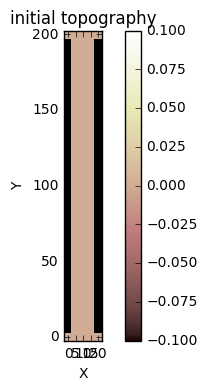

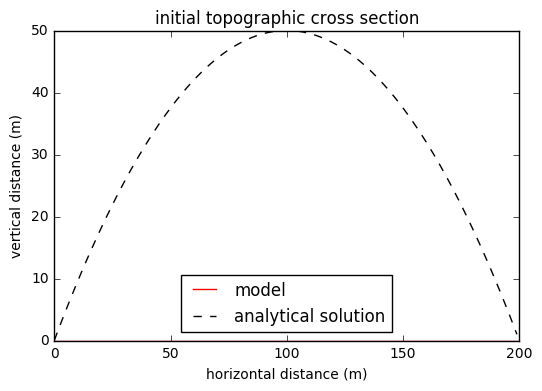

In [8]:
figure(1)
imshow_grid(mg, 'topographic__elevation')
title('initial topography')
figure(2)
elev_rast = mg.node_vector_to_raster(
            mg.at_node['topographic__elevation'])
plot(ys_grid, elev_rast[:, 2], 'r-', label='model')
plot(ys, zs, 'k--', label='analytical solution')
xlabel('horizontal distance (m)')
ylabel('vertical distance (m)')
legend(loc='lower center')
title('initial topographic cross section')

Now we are ready to evolve the landscape and compare it to the steady state solution.

Below is the time loop that does all the calculations, which are in the second and third lines of code. The rest of the code is for plotting the topography at the half-way time through the time-loop.

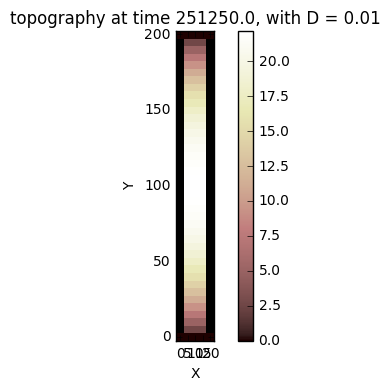

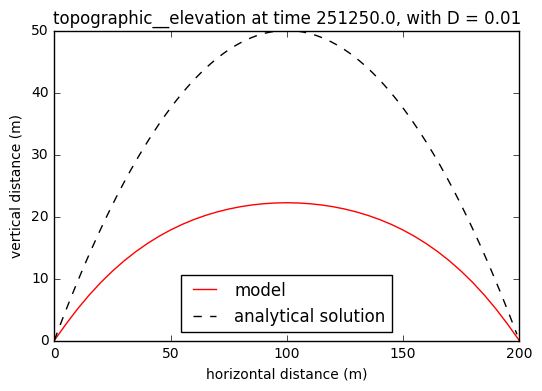

In [9]:
for i in range(nt):
    mg['node']['topographic__elevation'][mg.core_nodes] += uplift_per_step
    lin_diffuse.run_one_step(dt)
    time_counter += dt

    # All landscape evolution is the first two lines of loop.
    # Below is simply for plotting the topography halfway through the run
    if i == int(nt // 2):
        figure(1)
        imshow_grid(mg, 'topographic__elevation')
        title('topography at time %s, with D = %s'%(time_counter,D))
        figure(2)
        elev_rast = mg.node_vector_to_raster(
                       mg.at_node['topographic__elevation'])
        plot(ys_grid, elev_rast[:, 2], 'r-', label='model')
        plot(ys, zs, 'k--', label='analytical solution')
        xlabel('horizontal distance (m)')
        ylabel('vertical distance (m)')
        legend(loc='lower center')
        title('topographic__elevation at time %s, with D = %s'
              %(time_counter,D))

Now we plot the final cross-section.

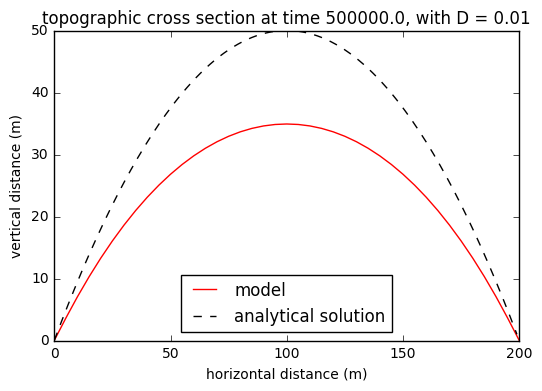

In [10]:
elev_rast = mg.node_vector_to_raster(
            mg.at_node['topographic__elevation'])
plot(ys_grid, elev_rast[:, 2], 'r-', label='model')
plot(ys, zs, 'k--', label='analytical solution')
xlabel('horizontal distance (m)')
ylabel('vertical distance (m)')
legend(loc='lower center')
title('topographic cross section at time %s, with D = %s'%(time_counter,D))

In [12]:
plot(mg.node_y[mg.core_nodes],mg.at_node['topographic__steepest_slope'][mg.core_nodes],'k.')

FieldError: topographic__steepest_slope

Has the landscape reached steady state yet? How do you know?







Answer: Not quite, but it is pretty close. Go back and rerun the cell with the time loop and also the plots of the final topography. (Remember you can rerun a cell with shift-return, or from the cell pull-down menu.) Has it reached steady state yet?  

What to do and hand in:
1. In the example illustrated here ($D$ = 0.01 m$^2$yr$^{-1}$ and $U$ = 0.0001 m yr$^{-1}$), hand in plots of the cross section when it has reached steady state, and when it has about 50% and 75% of the final steady state relief. Does it approach steady state linearly in time? (To answer the question, you will probably have to change the value of **run_time** a few times.)
2. What do you think will happen you increase $D$ by a factor of 10? Will the time to steady state differ? If yes, how? Will the topography be different? If yes, how and why? What does it mean physically, about processes, if $D$ increases? Answer these questions first, and then rerun the code with $D$ = 0.1 m$^2$yr$^{-1}$. Illustrate the final steady state topography. Discuss how these results differ from the results in question 1. It is OK if your intuition was wrong. 
3. What do you think will happen you increase $U$ by a factor of 10? Will the time to steady state differ? If yes, how? Will the topography be different? If yes, how and why? Answer these questions first, and then rerun the code with $U$ = 0.001 m yr$^{-1}$. (Make sure you change $D$ back to the original value of 0.01 m$^2$yr$^{-1}$.) Illustrate the final steady state topography. Discuss how these results differ from the results in question 1. It is OK if your intuition was wrong.

You should hand in a typed document that answers the above questions with supporting plots. Plots should be embedded in the text, or, if they all fall at the end, they need to be clearly labeled, e.g. each plot has a figure number and plots are referred to by figure number in the text.

Other questions you can explore.

1. What happens to time to steady state as you increase the length of your hillslope? 
2. Does grid resolution affect your answers? If so, how?


### Click here for more <a href="https://github.com/landlab/landlab/wiki/Tutorials">Landlab tutorials</a>